In [1]:
# For Google Colab use commands installing packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Install Pennylane and Pylatexenc in Google Colab
if IN_COLAB:
  !pip install pennylane pennylane-qiskit
  !pip install pylatexenc #for using MPL

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.6/249.6 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.0/318.0 kB 11.3 MB/s eta 0:00:00
  Installing build dependencies ... 

# **2024-01-18** N-Queens with VQA

## 1 Idea

## 2 Code

In [2]:
import pennylane as qml
# from pennylane import numpy as np
import numpy as np
import torch
from torch import optim
from torch import tensor

from collections import defaultdict
import networkx as nx
import copy
import math
from itertools import combinations
import sys

import matplotlib.pyplot as plt

### Functions

### Chess Class

In [3]:
class Chess:
  def __init__(self, size = 4, horses = []):
    '''
      Args :
        size(int) : size of Chess Board
        horses(list[list[int]]) : indexes(row, col) of placed horses, Not Duplicated with Same Row or Column
    '''
    is_nonempty = defaultdict(int)
    self.board = [[0 for _ in range(size)] for _ in range(size)]
    self.horses = horses
    self.size = size
    for h in horses:
      self.board[h[0]][h[1]] = 1
      is_nonempty[h[0]] += 1
    self.empty_rows = []
    self.nonempty_rows = []
    for i in range(size):
      if is_nonempty[i] == 1:
        self.nonempty_rows.append(i)
      else:
        self.empty_rows.append(i)

  def set_horses(self, new_horses):
    self.horses = self.horses + new_horses
    horses = self.horses
    size = self.size
    is_nonempty = defaultdict(int)
    for h in horses:
      self.board[h[0]][h[1]] = 1
      is_nonempty[h[0]] += 1
    self.empty_rows = []
    self.nonempty_rows = []
    for i in range(size):
      if is_nonempty[i] == 1:
        self.nonempty_rows.append(i)
      else:
        self.empty_rows.append(i)

  def draw(self):
    boxes = ['□', '◆']
    for row_board in self.board:
      for b in row_board:
        print(boxes[b], end ='')
      print()



### QML Class

In [47]:
class N_Queen_QML:
  def __init__(self, chess : Chess, num_of_layers = 2, N_iter = 500, device_type = "default.qubit", optimizer = "Adam", chk = False):
    # Prepare to ML
    self.chess = chess
    self.n = chess.size
    self.empty_rows = chess.empty_rows
    self.req_for_row = int(np.ceil(np.log2(self.n)))
    self.num_weights = 3 * self.req_for_row * len(self.empty_rows)  # 3 : Rx,Ry,Rz, (np.ceil(np.log2(board_size))) : 한 row를 표현하는 qubit 개수, len(empty_rows) : 필요한 행의 개수
    self.num_qubits = len(self.empty_rows) * self.req_for_row
    self.num_of_layers = num_of_layers
    self.N_iter = N_iter
    self.w = torch.tensor(torch.rand(self.num_of_layers * self.num_weights) * 2 * np.pi, requires_grad = True)
    self.lr = 0.1
    self.momentum = 1
    self.optimizer = optimizer

    # Prepare to Quantum
    self.dev = qml.device(device_type, wires = self.num_qubits)

    if chk:
      print("====== About Chess Class ======")
      print('Board Size : {} * {}'.format(self.n, self.n))
      print("Empty Rows :", self.empty_rows)

      print()
      print("====== About Quantum Settings ======")
      print("Required Qubit for 1 row :", self.req_for_row)
      print("Required Qubit for all Row :", self.num_qubits)

      print('num of w :', len(self.w))
      #print(self.w.detach().numpy())
      #print(np.shape(self.w.detach().numpy()))
      #print(self.empty_rows)

  #VQA Layer(Ansatz) building
  def vqa_layer(self): #Ansatz, thetas = w, size = board_size, empty_rows = empty_rows, n_layer = num_of_layers
      th_count = 0
      thetas = self.w
      n = self.n
      for i in range(self.num_of_layers):
        for j in range(self.num_qubits):
          qml.RX(thetas[th_count], j)
          th_count += 1
          qml.RY(thetas[th_count], j)
          th_count += 1
          qml.RZ(thetas[th_count], j)
          th_count += 1
        for j in range(self.num_qubits):
          qml.CNOT([j, (j+1) % self.num_qubits])

  #get state vector
  def state_vec(self, picture = False): # thetas = self.w, board = self.chess, num_of_layers = self.num_of_layers):

    @qml.qnode(self.dev, interface = 'torch')
    def inner_state_vec():
      self.vqa_layer() #Ansatz Apply
      return qml.probs()

    if picture:
      print(qml.draw_mpl(inner_state_vec)())
    return inner_state_vec()

  def main_circuit(self, w): # w = self.w

    @qml.qnode(self.dev, interface='torch')
    def inner_main_circuit(thetas = w, chess = self.chess, num_of_layers = self.num_of_layers):
      self.vqa_layer() #Ansatz Apply
      m_result = [qml.expval(qml.PauliZ(i)) for i in range(self.num_qubits)]
      return m_result

    return inner_main_circuit()

  def draw_circuit(self):
    self.state_vec(picture = True)
    return

  def make_probs_board(self, main_result):
    def make_index_list(n, probs, cut_range):
      result = []
      for i in range(2 ** n):
        b = bin(i)[2:].zfill(n)
        temp = 1
        for i in range(n):
          temp *= abs((int(b[i]) - probs[i]))
        result.append(temp)
      return result[:cut_range]

    chess = self.chess

    normalized_result = torch.stack(main_result, dim = 0).reshape(-1, self.req_for_row) / 2 + 0.5 # for 2 to row, [-1, 1, 1, -1, -1, -1] -> [0, 1], [1, 0], [0, 0]
    norm_index = 0

    if 0 in self.empty_rows:
      probs_board = torch.tensor(make_index_list(self.req_for_row, normalized_result[norm_index], self.n))
      norm_index += 1
    else:
      probs_board = torch.tensor(chess.board[0])

    for i in range(1, self.n):
      if i in self.empty_rows:
        probs_board = torch.vstack((probs_board, torch.stack(make_index_list(self.req_for_row, normalized_result[norm_index], self.n))))
        norm_index += 1
      else:
        probs_board = torch.vstack((probs_board, torch.stack([torch.tensor([e]) for e in chess.board[i]])))
    return probs_board

  def cost_fn(self, main_result):
    size = self.n
    ham = 0

    result = self.make_probs_board(main_result)
    # print(result)

    for i in self.empty_rows:
        ham += (torch.sum(result[i]) - 1) * (torch.sum(result[i]) - 1)
    for i in range(self.n):
        ham += (torch.sum(result.T[i]) - 1) * (torch.sum(result.T[i]) - 1)

    for i in range(2 * self.n - 3): # 대각선 개수 2 * size - 1 - 2 (대각선 요소 1개인 것)
        diag1 = torch.diagonal(result,i - 2)
        diag2 = torch.diagonal(torch.flip(result,[-1]),i-2)
        ham += torch.abs((torch.sum(diag1)) * (torch.sum(diag1)-1))
        ham += torch.abs((torch.sum(diag2)) * (torch.sum(diag2)-1))
    return ham

  def optimize(self, optimizer = "Adam", chk = False):
    loss = []
    if self.optimizer == "Adam":
      optimizer = optim.Adam([self.w], lr = self.lr) # lr : learning rate
    else:
      optimizer = optim.SGD([self.w], lr = self.lr, momentum = self.momentum) #lr : learning rate, SGD : gradient descent

    for iter in range(self.N_iter):
        # cost function
        # cost = my_cost(w, C1, num_of_layers)#main_circuit(w,C1,num_of_layers)
        cost = self.cost_fn(self.main_circuit(w = self.w))
        loss.append(float(cost))
        # Optimizing step
        # print(cost, type(cost))
        optimizer.zero_grad() # gradient 초기화
        cost.backward() # gradient 계산
        optimizer.step() # 함수 개선
        if chk:
          print('iteration number : ', iter,' cost is ', cost)

    plt.plot(np.arange(1, self.N_iter + 1), loss)
    plt.xlabel('N_iter')
    plt.ylabel('Loss')
    plt.show()

  def show_result(self):
    result = self.state_vec()
    result_prob = result.max()
    result_index = np.where(result == result_prob)
    binary_index = bin(result_index[0][0])[2:].zfill(self.num_qubits)

    print("Result State : {}, Probablity : {}".format(binary_index, result_prob))

    result_horses = []
    for i in range(len(self.empty_rows)):
      temp = 0
      digit = 1
      start = (i + 1) * self.req_for_row - 1
      for j in range(self.req_for_row):
        temp += (digit * int(binary_index[start - j]))
        digit *= 2
      result_horses.append(temp)

    horses_list = self.chess.horses
    for i in range(len(self.empty_rows)):
      number = self.empty_rows[i] * self.n + result_horses[i]
      horses_list.append([number // self.n, number % self.n])

    result_chess = Chess(self.n, horses_list)
    result_chess.draw()




□◆□□
□□□□
□□□□
□□□□
====== About Chess Class ======
Board Size : 4 * 4
Empty Rows : [1, 2, 3]

====== About Quantum Settings ======
Required Qubit for 1 row : 2
Required Qubit for all Row : 6
num of w : 36
tensor(0.)


<ipython-input-38-0ad83157ba09>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.w = torch.tensor(torch.rand(self.num_of_layers * self.num_weights) * 2 * np.pi, requires_grad = True)


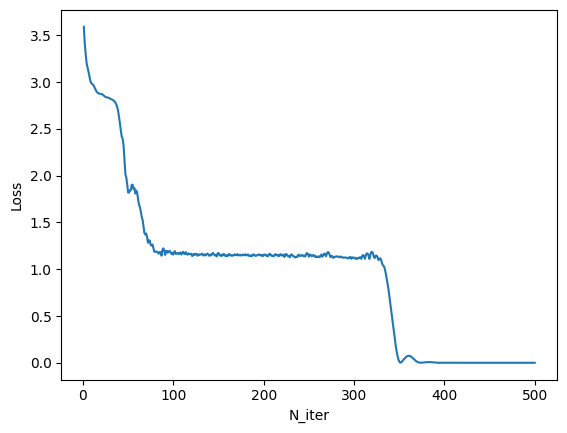

Result State : 110010, Probablity : 0.9999997615814209
□◆□□
□□□◆
◆□□□
□□◆□


In [45]:
C2 = Chess(4, [[0,1]])
C2.draw()
my_NQ = N_Queen_QML(C2, chk = True)
main_circuit_result = my_NQ.cost_fn([torch.tensor([e]) for e in [-1, -1, 1, 1, -1, 1]])
print(main_circuit_result)
my_NQ.optimize()
my_NQ.show_result()
# my_NQ.draw_circuit()

In [48]:
C2 = Chess(5, [[0, 4], [1, 2]])
C2.draw()
my_NQ = N_Queen_QML(C2, chk = True)
my_NQ.optimize()
my_NQ.show_result()
# my_NQ.draw_circuit()

□□□□◆
□□◆□□
□□□□□
□□□□□
□□□□□
====== About Chess Class ======
Board Size : 5 * 5
Empty Rows : [2, 3, 4]

====== About Quantum Settings ======
Required Qubit for 1 row : 3
Required Qubit for all Row : 9
num of w : 54


<ipython-input-47-543bce8d5eca>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.w = torch.tensor(torch.rand(self.num_of_layers * self.num_weights) * 2 * np.pi, requires_grad = True)


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 5 but got size 1 for tensor number 1 in the list.